In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import os
import gc
import multiprocessing
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning,message='Mean of empty slice')
import itertools

import seaborn as sns
import scipy

In [2]:
# import definitions_2018 as bd
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/users/jacob/Seafile/beeresults2019/'
comb_contents_dir = '/users/jacob/Seafile/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
#%cd 'directory-with-py-files'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

/Users/jacob/Seafile/Bees_sharedcodes/JD-2019data/drones/definitions_2019.py:26: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

# Load data - all histograms

In [3]:
junedaynumoffset=5

In [3]:
workercolors = bp.snscolors[[1,8]]
dronecolors = bp.snscolors[[0,9]]

In [ ]:
## importing the required  dataframe to create the XY-Histogramms 
daystoloadxy = np.arange(3,25,1)

for i,daynum in enumerate(daystoloadxy):
    filename = resultsdir+'dfxy_'+'dayhour'+'_'+str(daynum).zfill(zfilln)+'.hdf'
    if i==0:
        dfxy = pd.read_hdf(filename)
    else:
        dfxy = pd.concat((dfxy,pd.read_hdf(filename)))

# Distance from center of comb

In [6]:
## define which bins correspond to which frames, using rounded values
lbins = np.round(np.array([bd.div1_l, bd.div2_l, bd.ypixels])/bd.pixels_per_bin)
rbins = np.round(np.array([bd.div1_r, bd.div2_r, bd.ypixels])/bd.pixels_per_bin)
print(lbins,rbins)

[12. 23. 36.] [12. 23. 36.]


In [7]:
# rounded they are the same, so could just use one
lrbins = np.insert(lbins,0,0).astype(int)
# make a histogram mask
histframenums = np.tile(np.nan,(bd.numxbins,bd.numybins))
for i in range(3):
    histframenums[0:20,lrbins[i]:lrbins[i+1]] = i
for i in range(3):
    histframenums[21:,lrbins[i]:lrbins[i+1]] = i+3

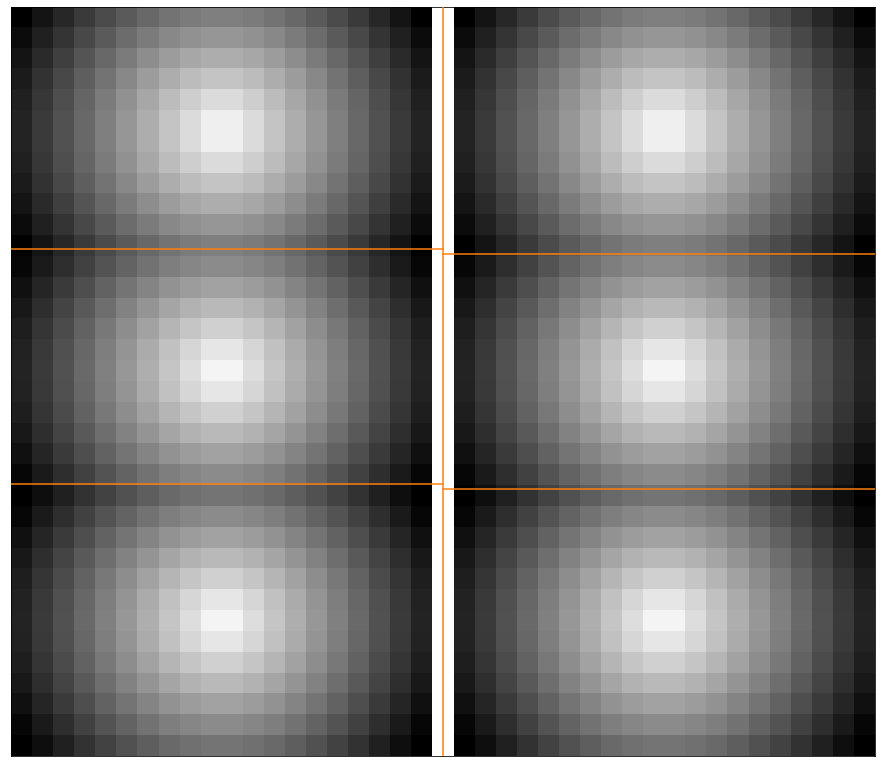

In [8]:
def nan_to_zero(x):
    temp = x.copy()
    temp[np.isnan(temp)] = 0
    return temp
# ax = bp.showframe()
# bp.showhist(nan_to_zero(histframenums),ax=ax)
# plt.show()

# use the framehist to make a "distance frame" histogram - distance from center
middledist = np.tile(np.nan,histframenums.shape)
for i in range(6):
    sel = histframenums==i
    perframehist = np.reshape(histframenums[sel],(20,-1))
    shape = np.array(perframehist.shape)
    middle = (shape-1)/2
    xx, yy = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    middledist[sel] = np.sqrt( (xx-middle[1])**2+(yy-middle[0])**2 ).flatten()
ax = bp.showframe()
bp.showhist(nan_to_zero(middledist),ax=ax)
plt.show()    

In [9]:
# for visualizing histogram + distance from center of comb
# f,ax=plt.subplots(1,1)
# f.set_size_inches(3,3)
# f.set_facecolor('white')  ## this is the best way to make the titles show up - its better than the dark_bg_hack    
# bp.showframe(ax=ax)
# bp.showhist(dayhist,ax=ax)    
# plt.title(np.round(c_dist_from_center[i],2),fontsize=14)
# plt.show()

np.nanmean(middledist)

6.239207435267493

In [10]:
cohortnums=[8,10,7,9]
print([bd.cohort_names[c] for c in cohortnums])
all_dist_from_center = np.tile(np.nan,(len(cohortnums),len(daystoloadxy)))
for c,cohortnum in enumerate(cohortnums):
    sel = (dfxy['Cohort ID']==cohortnum)
    for i,daynum in enumerate(daystoloadxy):
        dayhist = dfunc.flat_to_hist(np.mean(dfxy[sel & (dfxy['Day number']==daynum)],axis=0))
        all_dist_from_center[c,i] = np.nansum(middledist*dayhist)/np.nansum(dayhist)

['charlie_drones', 'delta_drones', 'charlie', 'delta']


/var/folders/sq/f41r2kzn2ngbwmv7p9lqfvp40000gp/T/ipykernel_2705/2174865.py:11: RuntimeWarning: invalid value encountered in double_scalars
  all_dist_from_center[c,i] = np.nansum(middledist*dayhist)/np.nansum(dayhist)


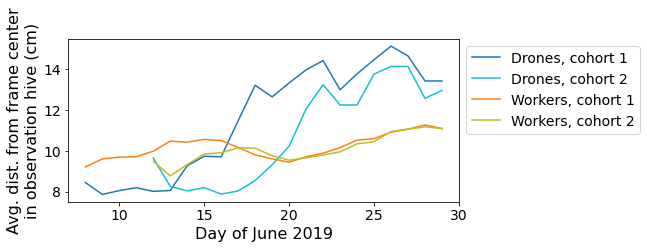

In [25]:
f,ax = plt.subplots(1,1)
f.set_size_inches(7,3)
conv = bd.pixels_per_bin/bd.pixels_per_cm  # cm/bin
for i in range(2):
    ax.plot(daystoloadxy+junedaynumoffset,all_dist_from_center[i]*conv,label='Drones, cohort '+str(i+1),c=dronecolors[i])
for i in range(2):
    ax.plot(daystoloadxy+junedaynumoffset,all_dist_from_center[i+2]*conv,label='Workers, cohort '+str(i+1),c=workercolors[i])
ax.tick_params(labelsize=14)
ax.set_xlim([7,30])
ax.set_xlabel('Day of June 2019',fontsize=16)
ax.set_ylabel('Avg. dist. from frame center\nin observation hive (cm)',fontsize=16)
ax.legend(bbox_to_anchor=(1,1),fontsize=14)
plt.savefig('image-output/combcenter.pdf')
plt.show()


## Supp - Histograms

In [16]:
savefigures = False
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'Supp-allhists.pdf')

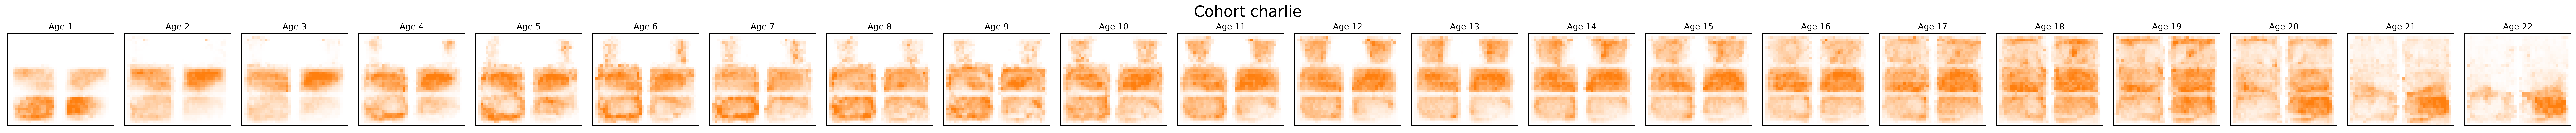

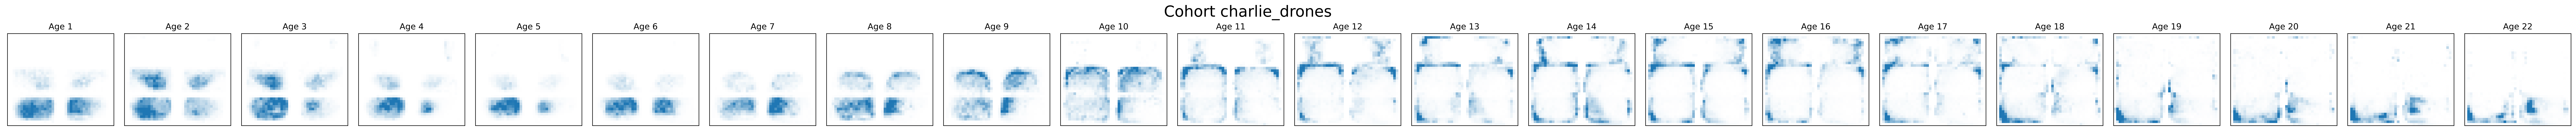

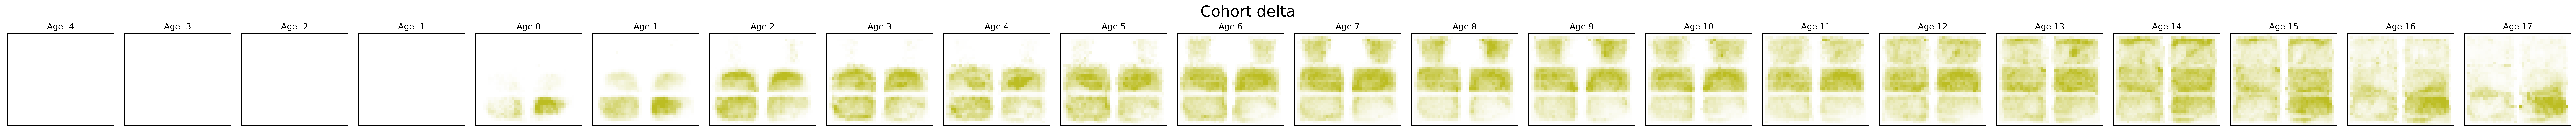

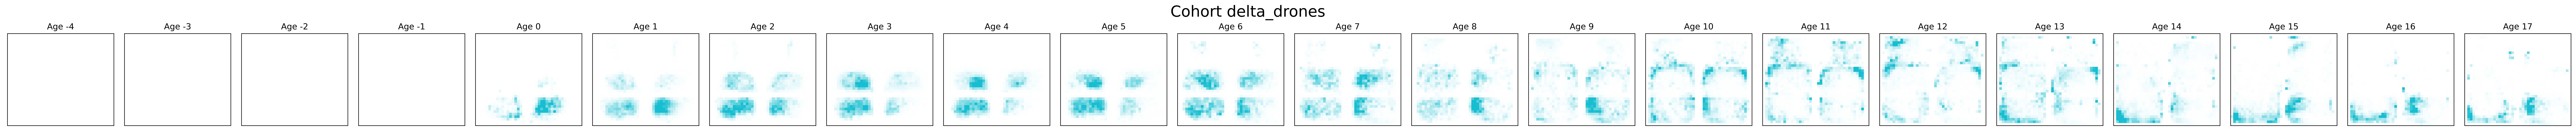

In [20]:
# Plot an example:  bees of a certain cohort, for each day loaded
cohortnum=8
tpcolors = [workercolors[0],dronecolors[0],workercolors[1],dronecolors[1]]
for cohortnum,color in zip([7,8,9,10],tpcolors):

    sel = (dfxy['Cohort ID']==cohortnum)
    bdaydaynum = np.where(bd.alldaytimestamps==bd.cohort_birthdates[cohortnum])[0][0]

    numcols = len(daystoloadxy)
    f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
    f.set_size_inches(numcols*3,3)
    f.set_dpi(600)
    f.set_facecolor('white')
    for i,daynum in enumerate(daystoloadxy):
        a=ax[i]
        dayhist = dfunc.flat_to_hist(np.mean(dfxy[sel & (dfxy['Day number']==daynum)],axis=0))
        bp.showhist(dayhist,ax=a,color=color)
        a.set_title('Age '+str(daynum-bdaydaynum))
    plt.suptitle('Cohort '+bd.cohort_names[cohortnum],fontsize=22,y=1)

    plt.subplots_adjust(wspace=0.1)
    pdf.savefig(f) if savefigures else None
    plt.show()


In [21]:
# allcomb = [dfunc.day_comb_data(comb_contents_dir,bd.alldaytimestamps[daynum]) for daynum in bd.comb_daynums]
# faster way to load - use the pickle files
allcomb = [pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb')) for daynum in daystoloadxy]

In [22]:
# plot all comb measurements along a line
numcols = len(daystoloadxy)
f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
f.set_size_inches(numcols*3,3)
f.set_dpi(600)
fontsize=12

# f,ax = plt.subplots(1,len(,sharex=True,sharey=True)
# basesize=10
# # fontsize=basesize*3
# f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0]*(bd.ypixels/(2*bd.xpixels)))

for i,daynum in enumerate(daystoloadxy):
    a=ax[i]
    bp.showcomb(allcomb[i],ax=a)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

# legend hack
a = ax[-1]
for i in range(len(bd.substrate_names)-1):
    if i==5:  # dance floor
#         a.plot(0,0,label='Dances observed',c=bd.cmap_comb(i),lw=5)
#         a.plot(0,0,label='Dance floor (combined)',linestyle='--',lw=5,c=bd.cmap_comb(i))        
        None
    else:
        a.plot(0,0,label=bd.substrate_names[i],c=bd.cmap_comb(i),lw=5)
a.legend(fontsize=fontsize,bbox_to_anchor=(1.05, 1.04))
linelength=10 # in cm
a.plot([0,0+linelength*bd.pixels_per_cm],[100,100],linewidth=2,color='k')
f.set_facecolor('white')
pdf.savefig(f) if savefigures else None
plt.savefig('image-output/temp.pdf')
plt.show()


In [23]:
pdf.close() if savefigures else None
savefigures=False

# Showing exit distance on the frame plot

In [29]:
# create a blank histogram, and then calculate the distance for each
exitdist_histogram = np.tile(0,(bd.numxbins,bd.numybins))
print(bd.numxbins)

41


In [30]:
dfunc.getexitdistance(np.array([10]),np.array([20]),np.array([0]))

array([6579.34616812])

In [50]:
f = lambda x: np.array([x])

cam1=21
for i in range(0,cam1):
    for j in range(bd.numybins):
        x = f(i)*bd.pixels_per_bin
        y = f(j)*bd.pixels_per_bin
        exitdist_histogram[i,j] = dfunc.getexitdistance(x,y,f(1))[0]
        
for i in range(0,20):
    for j in range(bd.numybins):        
        x = f(i)*bd.pixels_per_bin
        y = f(j)*bd.pixels_per_bin
        exitdist_histogram[i+cam1,j] = dfunc.getexitdistance(x,y,f(0))[0]        
        
    

In [74]:
numpoints=100
x,y = np.linspace(0,bd.xpixels,numpoints),np.linspace(0,bd.ypixels,numpoints)
xv, yv = np.meshgrid(x, y)
cam0dist = dfunc.getexitdistance(xv.flatten(),yv.flatten(),np.zeros(numpoints**2))/bd.pixels_per_cm
cam1dist = dfunc.getexitdistance(xv.flatten(),yv.flatten(),np.ones(numpoints**2))/bd.pixels_per_cm


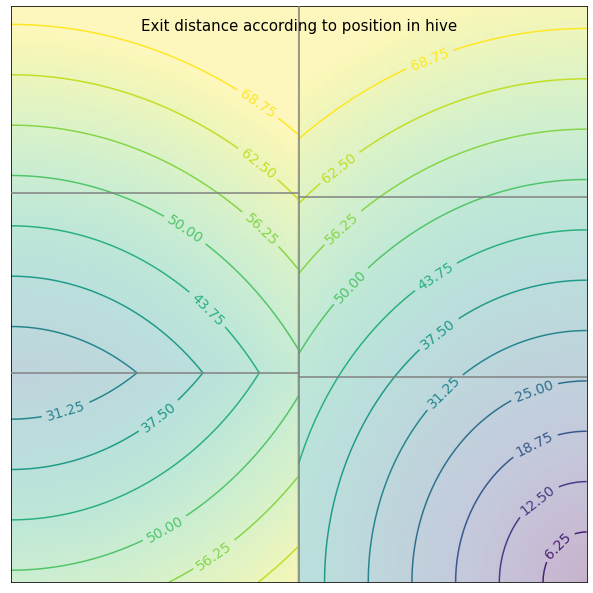

In [95]:
f,ax = bp.createnewimage(size=8)
ax = bp.showframe(ax=ax,color='gray')
# ax.pcolormesh(xv,yv,cam0dist.reshape(numpoints,numpoints))
# camera0 is near the exit, so add bd.xpixels to shift it
levels = np.arange(0,6000,500)/bd.pixels_per_cm
ax.pcolormesh(xv+bd.xpixels,yv,cam0dist.reshape(numpoints,numpoints),alpha=0.3,shading='nearest',vmin=0,vmax=6000/bd.pixels_per_cm)
cs = ax.contour(xv+bd.xpixels,yv,cam0dist.reshape(numpoints,numpoints),levels=levels,vmin=0,vmax=levels[-1])
ax.clabel(cs, inline=True, fontsize=14,fmt='%1.2f')
# camera1 is backside (left), so don't add pixels
ax.pcolormesh(xv,yv,cam1dist.reshape(numpoints,numpoints),alpha=0.3,shading='nearest',vmin=0,vmax=levels[-1])
cs = ax.contour(xv,yv,cam1dist.reshape(numpoints,numpoints),levels=levels,vmin=0,vmax=levels[-1])
ax.clabel(cs, inline=True, fontsize=14,fmt='%1.2f') 
plt.suptitle('Exit distance according to position in hive',fontsize=15)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
f.set_facecolor('white')
plt.savefig('image-output/exitdist-frame.pdf')
plt.show()

# Trajectories video

In [4]:
# time period and variables, calculated using exitdistthreshold=2500 (main paper analysis), and copied here
collectiveactivated = np.array([[-1, -1],
  [170, 192],
  [179, 198],
  [189, 202],
  [168, 200],
  [176, 203],
  [178, 200],
  [-1, -1],
  [184, 186],
  [186, 194],
  [164, 199],
  [176, 202],
  [181, 206],
  [185, 207],
  [190, 208],
  [187, 203],
  [182, 215]])
daynumstoshow = np.array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [10]:
# loop through and save just the drone trajectories, in order to access faster/easier
drone_uids = (bd.cohort_uids[8],bd.cohort_uids[10])

for iday in range(14,15):
    daynum = daynumstoshow[iday]
    day = bd.alldaytimestamps[daynum]
    print(day)
    savefile = resultsdir+'beetrajectories'+'_'+str(daynum).zfill(3)+'.hdf'
    df = pd.read_hdf(savefile)
    dronefile = resultsdir+'dronetrajectories'+str(daynum).zfill(3)+'.pkl'
    pickle.dump(df[df['uid'].isin(np.concatenate(drone_uids))],open(dronefile,'wb'))
del df

2019-06-27 00:00:00


## create video using all drone trajectories read in at once

In [6]:
## VIDEO OF THE HIGHLIGHTED SEGMENT, by saving individual frames then combining
import subprocess, glob
import matplotlib
# using this and plt close, it doesn't display!  https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
%matplotlib inline  


In [11]:
# read in data from drone trajectories, only keeping the hours wanted
hourstart = 12
hourend = 18
backshow=180
framenumstart = int(hourstart*60*60*3-backshow)
framenumend = int(hourend*60*60*3)
# load data
for iday in range(1,len(daynumstoshow)):
    print(iday)
    daynum = daynumstoshow[iday]    
    filename = resultsdir+'dronetrajectories'+str(daynum).zfill(3)+'.pkl'
    if iday==1:
        dfdrones = pickle.load(open(filename,'rb'))
        dfdrones = dfdrones[(dfdrones['framenum']>=framenumstart)&(dfdrones['framenum']<=framenumend)]
    else:
        new = pickle.load(open(filename,'rb'))
        new = new[(new['framenum']>=framenumstart)&(new['framenum']<=framenumend)]
        dfdrones = pd.concat((dfdrones,new))
        del new

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [12]:
drone_uids = (bd.cohort_uids[8],bd.cohort_uids[10])


cmapspeed=plt.get_cmap('plasma')
def singleaxplot(ax,df,framenum,backshow=180,maxspeedcm=3,maxcmap = 0.8):
    dfsel = df[(df['framenum']>=(framenum-backshow))&(df['framenum']<=framenum)]
    for i in range(2):
        for uid in drone_uids[i]:
            x,y,camera = dfsel.loc[dfsel['uid']==uid,['x','y','camera']].values.T
            if len(x)>=3:
                spd = np.sqrt(np.diff(x)**2+np.diff(y)**2)
                meanspd = np.mean(spd[np.diff(camera)==0]/bd.pixels_per_cm)*3
                color = cmapspeed(np.minimum(meanspd/maxspeedcm,0.999))
                bp.plotbee_xy(x,y,camera,ax=ax,color=color,alpha=0.9,rasterized=True)
                ax.set_facecolor([0.5,0.5,0.5])
    bp.showframe(ax=ax,color='k')
    return f,ax

In [13]:
print('total time for each trajectory segment color:',backshow/3,'seconds')

total time for each trajectory segment color: 60.0 seconds


In [ ]:
folder = '/Users/jacob/Seafile/video-output/'
videoname = 'DroneMovement_'+str(hourstart)+'-'+str(hourend)+'.mp4'
    
maxspeedcm = 3
framesforvideo = range(framenumstart+backshow,framenumend, 30)
# framesforvideo = range(framenumstart+backshow,framenumstart+backshow+900,30)
# framesforvideo = range(framenumstart+backshow,framenumstart+backshow+30, 30)
for findex,framenum in enumerate(framesforvideo):
    if findex<=1637:
        continue
    if np.mod(findex,10)==0:
        print(findex,len(framesforvideo))
    f, ax = plt.subplots(3,6,sharex=True,sharey=True)
    basesize=4
    f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0])
    f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)            
    f.set_facecolor('white')
    a=ax[0,0]
    a.set_xlim([0,2*bd.xpixels])
    a.set_ylim([bd.ypixels,0])  # note this is backwards.. this makes it show 'zero' 
    
    allminutes,seconds = np.round(np.divmod(framenum/3,60)).astype(int)
    hours,minutes = np.round(np.divmod(allminutes,60)).astype(int)
    for i,daynum in enumerate(daynumstoshow[1:]):
        row,col = np.divmod(i,ax.shape[1])
        a=ax[row,col]
        singleaxplot(a,dfdrones[dfdrones['daynum']==daynum],framenum,maxspeedcm=maxspeedcm)
        clr = (bp.snscolors[0] if (daynum==15) else 'k')
        a.set_title('June '+str(daynum+5),y=0.9,x=0.22,fontsize=26,color=clr)

    # formatting   
    for a in ax.flatten():
        a.get_xaxis().set_ticks([])
        a.get_yaxis().set_ticks([])    

    # clock
    a=ax[-1,-1]
    a.set_title(str(hours).zfill(2)+':'+str(minutes).zfill(2)+':'+str(seconds).zfill(2),y=0.5,fontsize=45)
    a.axis('off')
    plt.subplots_adjust(wspace=0.02,hspace=0.02)
    a.tick_params(labelsize=20)

    # speed legend
    a=ax[-1,-2]
    vals = np.array([[0,maxspeedcm]])
    img = plt.imshow(vals, cmap=cmapspeed)
    # plt.gca().set_visible(False)
    cax = plt.axes([4.45/6, 0.06/3, 0.08/6, 0.7/3])
    cb = plt.colorbar(orientation="vertical", cax=cax)
    cb.ax.tick_params(labelsize=20)
    cb.ax.set_title('Avg. speed in 1-minute\nwindow (cm/sec)',fontsize=22,y=1.03)
    a.axis('off')

    plt.savefig(folder + "/file%05d.png" % findex,dpi=100)
    # plt.show()        
    plt.close(f)

subprocess.call([
    'ffmpeg', '-framerate', '15', '-i', folder+'file%05d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    folder+videoname
])

for file_name in glob.glob(folder+"*.png"):
    os.remove(file_name)        